In [14]:
using QuantumOptics, PyPlot

In this example we will show how can one evolve a wavepacket in 2 spatial dimensions instead of 1. We will do that using [`tensor`](@ref) products between the two spaces. We start similarly with the 1D case, by defining a position basis and a momentum operator for each dimension.

In [2]:
Npoints = 50
Npointsy = 50

xmin = -30
xmax = 30
b_position = PositionBasis(xmin, xmax, Npoints)
b_momentum = MomentumBasis(b_position)

ymin = -20
ymax = 20
b_positiony = PositionBasis(ymin, ymax, Npointsy)
b_momentumy = MomentumBasis(b_positiony)

xsample = samplepoints(b_position)
ysample = samplepoints(b_positiony)

Txp = transform(b_position, b_momentum)
Tpx = transform(b_momentum, b_position)
Typ = transform(b_positiony, b_momentumy)
Tpy = transform(b_momentumy, b_positiony)

Hkinx = LazyProduct(Txp, momentum(b_momentum)^2/2, Tpx)
Hkiny = LazyProduct(Typ, momentum(b_momentumy)^2/2, Tpy)

LazyProduct(dim=50x50)
  basis: Position(xmin=-20.0, xmax=20.0, N=50)
  operators: 3

The kinetic energy is the standard quadratic form, defined as in the 1D case. Normally the Hamiltonian then is the sum of `Hkinx` and `Hkiny`. However, we cannot "just" sum these two expressions, because they are defined in a different basis. What we have to do is to create a *composite* basis:

In [3]:
b_comp = b_position ⊗ b_positiony

[Position(xmin=-30.0, xmax=30.0, N=50) ⊗ Position(xmin=-20.0, xmax=20.0, N=50)]

Notice that `⊗` is just a shorthand for the function `tensor`:

In [4]:
?tensor

search: tensor LazyTensor operators_lazytensor



```
tensor(x, y, z...)
```

Tensor product of the given objects. Alternatively, the unicode symbol ⊗ (\otimes) can be used.

```
tensor(x::Basis, y::Basis, z::Basis...)
```

Create a [`CompositeBasis`](@ref) from the given bases.

Any given CompositeBasis is expanded so that the resulting CompositeBasis never contains another CompositeBasis.

```
tensor(x::Ket, y::Ket, z::Ket...)
```

Tensor product $|x⟩⊗|y⟩⊗|z⟩⊗…$ of the given states.

```
tensor(x::Operator, y::Operator, z::Operator...)
```

Tensor product $\hat{x}⊗\hat{y}⊗\hat{z}⊗…$ of the given operators.

```
tensor(x::Ket, y::Bra)
```

Outer product $|x⟩⟨y|$ of the given states.


Now that we have a composite basis, we can re-write each kinetic energy term to this composite basis. This is also possible with `Lazy` operations.

In [5]:
Hkinx_comp = LazyTensor(b_comp, [1, 2], [Hkinx, one(b_positiony)])
Hkiny_comp = LazyTensor(b_comp, [1, 2], [one(b_position), Hkiny])

LazyTensor(dim=2500x2500)
  basis: [Position(xmin=-30.0, xmax=30.0, N=50) ⊗ Position(xmin=-20.0, xmax=20.0, N=50)]
  operators: 2
  indices: [1,2]

Now we will add a two-dimensional potential. If we wanted to add a one-dimensional potential $V(x)$ the process is identical to the 1D case

In [6]:
V0 = 4. # Height of Barrier
d = 5 # Width of Barrier
function V_barrier(x)
    if x < -d/2 || x > d/2
        return 0.
    else
        return V0
    end
end
V = potentialoperator(b_position, V_barrier)
# Re-write in 2D form:
V_comp = LazyTensor(b_comp, [1, 2], [V, one(b_positiony)])

LazyTensor(dim=2500x2500)
  basis: [Position(xmin=-30.0, xmax=30.0, N=50) ⊗ Position(xmin=-20.0, xmax=20.0, N=50)]
  operators: 2
  indices: [1,2]

However, making a truly 2D potential is a tiny bit more involved. The first thing you need to understand is that all that `potentialoperator` does is create a `diagonaloperator` (since the potential function is always a diagonal operator). So, considering the fact that the operators x and y are diagonal in a position basis (and hence also their tensor product), applying a function to a tensor product x ⊗ y results in a diagonal operator where the function is applied to each element of a diagonal.

This is easily done in the 2D case like


In [7]:
potential(x,y) = sin(x*y) + cos(y)
Vvec = [potential(x, y) for x in xsample for y in ysample];

# V_comp = diagonaloperator(b_comp, Vvec) # we will use the 1D for visualization

Then one creates the full Hamiltonian simply by combining the kinetic and potential terms

In [8]:
H = LazySum(Hkinx_comp, Hkiny_comp, V_comp)

LazySum(dim=2500x2500)
  basis: [Position(xmin=-30.0, xmax=30.0, N=50) ⊗ Position(xmin=-20.0, xmax=20.0, N=50)]
  operators: 3

Now we can perform the time evolution. Unfortunately `timeevolution.schroedinger` currently has no implementation that works with a LazyTensor operator consisting of LazyProduct operators (The issue tracking this is here: https://github.com/qojulia/QuantumOptics.jl/issues/190).

This means that the Hamiltonian matrix has to be recasted from Lazy form to "normal" form

In [9]:
Hfull = sparse(full(H));

Now we will create a wavepacket in 2D and evolve it:

In [10]:
ψx = gaussianstate(b_position, -10.0, 1.5, 2)
ψy = gaussianstate(b_positiony, 0, 0.5, 2)
ψ = ψx ⊗ ψy # again tensor product

T = collect(0.0:0.1:15.0)
tout, C = timeevolution.schroedinger(T, ψ, Hfull);

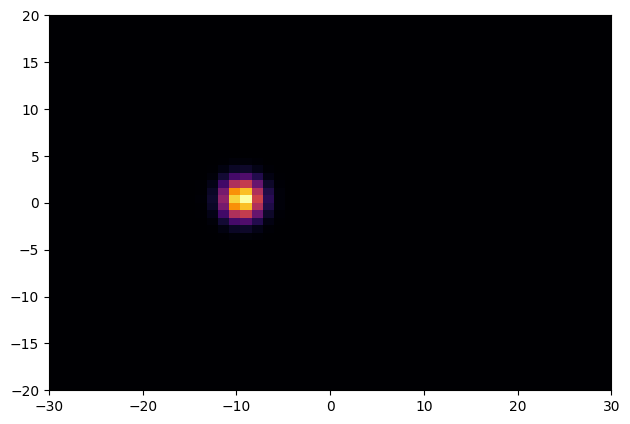

In [11]:
c = C[1]
data = reshape(abs2.(c.data), (Npoints, Npointsy))'
norm = maximum(data)
function plot_wp(i)
    data = reshape(abs2.(C[i].data), (Npoints, Npointsy))'
    figure()
    ima = imshow(data, origin = "lower", extent = [xmin, xmax, ymin, ymax],
    cmap = "inferno", vmax = norm)
    tight_layout()
end
plot_wp(1)

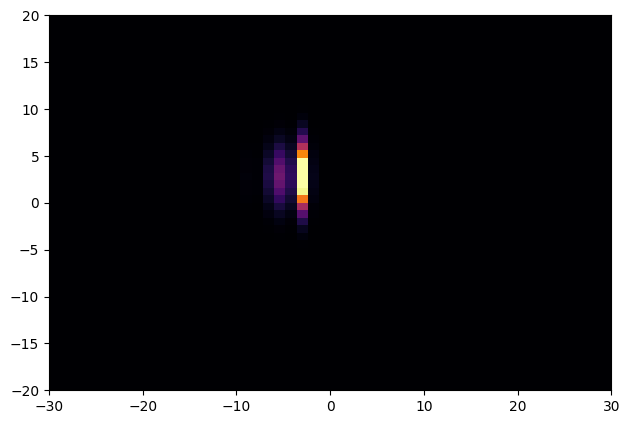

In [12]:
plot_wp(50)


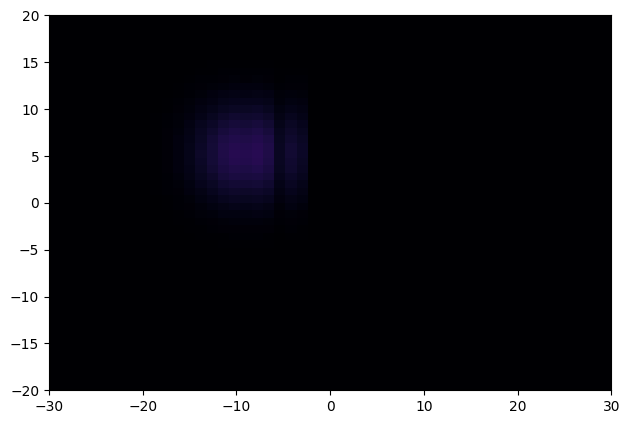

In [13]:
plot_wp(100)